Extracting ORB features from training images...
Processed 1290 images, extracted descriptors: 1275
Processed 281 images, extracted descriptors: 278
Processed 4772 images, extracted descriptors: 4654
Reducing dimensionality using PCA...
Training LinearSVC classifier...
Predicting on validation set...
Accuracy: 73.11%
Calculating confusion matrix...


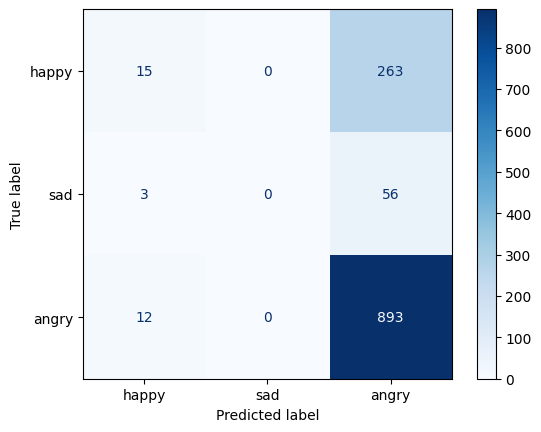

In [1]:
import os
import cv2
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Load and process images
def load_images_from_folder(folder_path, label, orb, max_features):
    image_paths = []
    descriptors_list = []
    labels = []
    
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                image_path = os.path.join(root, file)
                image_paths.append(image_path)
                img = cv2.imread(image_path)
                if img is None:
                    continue  
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                keypoints, descriptors = orb.detectAndCompute(gray, None)

                if descriptors is not None:
                    flattened_descriptors = descriptors.flatten()
                    if len(flattened_descriptors) < max_features:
                        flattened_descriptors = np.pad(flattened_descriptors, 
                                                       (0, max_features - len(flattened_descriptors)), 
                                                       mode='constant')
                    else:
                        flattened_descriptors = flattened_descriptors[:max_features]

                    descriptors_list.append(flattened_descriptors)
                    labels.append(label)

    print(f"Processed {len(image_paths)} images, extracted descriptors: {len(descriptors_list)}")
    return descriptors_list, labels

train_path = r"C:\Users\DEEPTHI\Desktop\Recognition\DATASET\train"
label_map = {'happy': 0, 'sad': 1, 'angry': 2}

max_keypoints = 200  
max_features = max_keypoints * 32  
orb = cv2.ORB_create(nfeatures=max_keypoints)

print("Extracting ORB features from training images...")
train_descriptors = []
train_labels = []

for label, class_idx in label_map.items():
    folder_path = os.path.join(train_path, label)
    if not os.path.exists(folder_path):
        print(f"Error: Directory {folder_path} does not exist")
        continue
    
    descriptors, labels = load_images_from_folder(folder_path, class_idx, orb, max_features)
    train_descriptors.extend(descriptors)
    train_labels.extend(labels)

if len(train_descriptors) == 0:
    print("Error: No descriptors found in training data. Exiting...")
    exit()

X = np.array(train_descriptors, dtype=np.float32)
y = np.array(train_labels)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Reducing dimensionality using PCA...")
pca = PCA(n_components=50) 
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

print("Training LinearSVC classifier...")
svm = LinearSVC(max_iter=5000)
svm.fit(X_train_pca, y_train)

print("Predicting on validation set...")
y_pred = svm.predict(X_val_pca)

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("Calculating confusion matrix...")
conf_matrix = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(label_map.keys()))
disp.plot(cmap="Blues")
